In [1]:
import tensorflow as tf
import os
import numpy as np
import random
SEED = 0
#------------------------------------------------------------------------------------
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
#------------------------------------------------------------------------------------
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)
#-----------------------------------------------------------------------------------

In [2]:
%matplotlib notebook
import pandas as pd
from data_extraction import *
from resp_signal_extraction import *
from rr_extration import *
from sklearn.preprocessing import MinMaxScaler
import re
import pickle as pkl
from tf_model import *
from tf_model_evi import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import evidential_deep_learning as edl
import matplotlib.pyplot as plt
import datetime
from filters import *
import plotly as py
#import plotly.figure_factory as ff
import ipywidgets as widgets
import plotly.graph_objs as go
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#py.offline.init_notebook_mode(connected = True)
#from plotly import tools
import plotly.express as px
import tensorflow_probability as tfp
from keras import backend as K
import seaborn as sns
from timeit import default_timer as timer
import time

In [3]:
input_conf = 'RespNet'

In [4]:
with open('output','rb') as f:
    output_data = pkl.load(f)

with open('input','rb') as f:
    input_data = pkl.load(f)

with open('raw_signal.pkl','rb') as f:
    raw_data = pkl.load(f)

#input_copy = input_data
input_data = np.transpose(input_data, (0,2,1))
raw_data = np.transpose(raw_data, (0,2,1))
annotation = pd.read_pickle('/media/acrophase/pose1/charan/BR_Uncertainty/DL_BASED_METHOD/annotation.pkl')
reference_rr = (annotation['Reference_RR'].values).reshape(-1,1)
activity_id = (annotation['activity_id'].values).reshape(-1,1)

input_data = np.around(input_data , decimals = 4)
raw_data = np.around(raw_data , decimals = 4)
output_data = np.around(output_data , decimals = 4)
reference_rr = np.around(reference_rr , decimals = 4)

tensor_input = tf.convert_to_tensor(input_data, dtype = 'float32')
tensor_output = tf.convert_to_tensor(output_data, dtype = 'float32')
tensor_ref_rr = tf.convert_to_tensor(reference_rr, dtype = 'float32')
tensor_raw_data = tf.convert_to_tensor(raw_data, dtype = 'float32')

training_ids = annotation['patient_id'] < 13

x_train_data = tensor_input[tf.convert_to_tensor(training_ids.values)]
x_test_data = tensor_input[tf.convert_to_tensor(~(training_ids.values))]
x_train_ref_rr = tensor_ref_rr[tf.convert_to_tensor(training_ids.values)]
x_test_ref_rr = tensor_ref_rr[tf.convert_to_tensor(~(training_ids.values))]
x_train_raw_sig = tensor_raw_data[tf.convert_to_tensor(training_ids.values)]
x_test_raw_sig = tensor_raw_data[tf.convert_to_tensor(~(training_ids.values))]

y_train_data = tensor_output[tf.convert_to_tensor(training_ids.values)]
y_test_data = tensor_output[tf.convert_to_tensor(~(training_ids.values))]

train_activity_id = activity_id[training_ids.values]
test_activity_id = activity_id[~(training_ids.values)]

2022-02-11 20:57:29.625244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-11 20:57:29.630820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-11 20:57:29.631452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-11 20:57:29.646843: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
if input_conf == 'confa':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_raw_sig , x_train_ref_rr))
        train_dataset = train_dataset.shuffle(len(x_train_raw_sig)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_raw_sig , x_test_ref_rr))
        test_dataset = test_dataset.batch(128)

if input_conf == 'confb':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_raw_sig , y_train_data, x_train_ref_rr))
        train_dataset = train_dataset.shuffle(len(x_train_data)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_raw_sig , y_test_data, x_test_ref_rr))
        test_dataset = test_dataset.batch(128)
                
if input_conf == 'confc':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_data , y_train_data))
        train_dataset = train_dataset.shuffle(len(x_train_data)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_data , y_test_data))
        test_dataset = test_dataset.batch(128)
        
if input_conf == 'confd':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_data , x_train_ref_rr))
        train_dataset = train_dataset.shuffle(len(x_train_data)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_data , x_test_ref_rr))
        test_dataset = test_dataset.batch(128)
        
if input_conf == 'confe':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_data , y_train_data, x_train_ref_rr))
        train_dataset = train_dataset.shuffle(len(x_train_data)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_data , y_test_data, x_test_ref_rr))
        test_dataset = test_dataset.batch(128)
        
if input_conf == 'RespNet':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_raw_sig , y_train_data))
        train_dataset = train_dataset.shuffle(len(x_train_raw_sig)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_raw_sig , y_test_data))
        test_dataset = test_dataset.batch(128)

    

In [6]:
if input_conf == 'confa':
    model_input_shape = (2048,3)
    model  = BRUnet_raw_encoder(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/DL_BASED_METHOD/SAVED_MODELS/confa/best_model_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    start = time.time()
    for step , (x_batch_test_raw, x_batch_test_ref_rr) in enumerate(test_dataset):
        output = model(x_batch_test_raw)
        test_loss = loss_fn(x_batch_test_ref_rr , output)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)
    end = time.time()
    model.summary()
    print(end - start)
#-------------------------------------------------------------------------------------------------------------------
if input_conf == 'confb':
    model_input_shape = (2048,3)
    model  = BRUnet_raw_multi(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/DL_BASED_METHOD/SAVED_MODELS/confb/best_model_100.h5')        
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    final_output_rr = tf.convert_to_tensor([])
    start = time.time()
    for step , (x_batch_test_raw , y_batch_test , x_batch_test_ref_rr) in enumerate(test_dataset):
        test_output,test_out_rr = model(x_batch_test_raw)
        test_loss_resp = loss_fn(y_batch_test  , test_output)
        test_loss_rr = loss_fn(x_batch_test_ref_rr , test_out_rr)
        test_loss = test_loss_resp + test_loss_rr
        if step == 0:
            final_output = test_output
            final_output_rr = test_out_rr
        else:
            final_output = tf.concat([final_output , test_output] , axis = 0)
            final_output_rr = tf.concat([final_output_rr , test_out_rr] , axis = 0)
        test_loss_list.append(test_loss)
    end = time.time()
    model.summary()
    print(end-start)
#-------------------------------------------------------------------------------------------------------------------
if input_conf == 'confc':
    model_input_shape = (128,3)
    model  = BRUnet(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/DL_BASED_METHOD/SAVED_MODELS/confc/best_model_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    start = time.time()
    for step,(x_batch_test , y_batch_test) in enumerate(test_dataset):
        output = model(x_batch_test)
        test_loss = loss_fn(y_batch_test,output)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)
    end = time.time()
    model.summary()
    print(end-start)

#------------------------------------------------------------------------------------------------------------------
if input_conf == 'confd':
    model_input_shape = (128,3)
    model  = BRUnet_Encoder(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/DL_BASED_METHOD/SAVED_MODELS/confd/best_model_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    start = time.time()
    for step , (x_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
        output = model(x_batch_test)
        test_loss = loss_fn(x_batch_test_ref_rr , output)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)
    end = time.time()
    model.summary()
    print(end - start)
#-----------------------------------------------------------------------------------------------------------------
if input_conf == 'confe':
    model_input_shape = (128,3)
    model  = BRUnet_Multi_resp(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/DL_BASED_METHOD/SAVED_MODELS/confe/best_model_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    final_output_rr = tf.convert_to_tensor([])
    start = time.time()
    for step , (x_batch_test,y_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
        test_output,test_out_rr = model(x_batch_test)
        test_loss_resp = loss_fn(y_batch_test  , test_output)
        test_loss_rr = loss_fn(x_batch_test_ref_rr , test_out_rr)
        test_loss = test_loss_resp + test_loss_rr
        if step == 0:
            final_output = test_output
            final_output_rr = test_out_rr
        else:
            final_output = tf.concat([final_output , test_output] , axis = 0)
            final_output_rr = tf.concat([final_output_rr , test_out_rr] , axis = 0)
        test_loss_list.append(test_loss)
    end = time.time()
    model.summary()
    print(end-start)

#--------------------------------------------------------------------------------------------------------------------
if input_conf == 'RespNet':
    model_input_shape = (2048,3)
    model  = BRUnet_raw(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/DL_BASED_METHOD/SAVED_MODELS/respnet/best_model_3100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    start = time.time()
    for step , (x_batch_test_raw,y_batch_test) in enumerate(test_dataset):
        output = model(x_batch_test_raw)
        test_loss = loss_fn(y_batch_test , output)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)
    end = time.time()
    model.summary()
    print(end - start)
        
#-------------------------------------------------------------------------------------------------------------------


2022-02-11 20:57:30.973808: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8202


Model: "br_unet_raw"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 1024, 32)          43584     
_________________________________________________________________
sequential_9 (Sequential)    (None, 512, 64)           78528     
_________________________________________________________________
sequential_14 (Sequential)   (None, 256, 128)          230272    
_________________________________________________________________
sequential_19 (Sequential)   (None, 128, 256)          959744    
_________________________________________________________________
sequential_24 (Sequential)   (None, 64, 256)           1056256   
_________________________________________________________________
sequential_29 (Sequential)   (None, 32, 512)           3821952   
_________________________________________________________________
sequential_34 (Sequential)   (None, 16, 512)           

In [7]:
def extremas_extraction(signal):
    avg_breath_duration = np.array([])
    extrema_relevent = []
    for item in signal:
        amplitude = np.array([])
        pos_peaks , _ = scipy.signal.find_peaks(item , height = [-3000,3000])
        neg_peaks , _ = scipy.signal.find_peaks(-1*item , height = [-3000 , 3000])
        extremas = np.concatenate((pos_peaks , neg_peaks))
        extremas = np.sort(extremas)
        for i in range(len(extremas)):
            amplitude = np.append(amplitude , item[int(extremas[i])])
        amplitude_diff = np.abs(np.diff(amplitude))
        q3 = np.percentile(amplitude_diff , 75)
        threshold = 0.3*q3
        eliminate_pairs_of_extrema = 1
        while(eliminate_pairs_of_extrema):
            amps = np.array([])
            if len(extremas)<3:
                eliminate_pairs_of_extrema = 0
                continue
            for i in range(len(extremas)):
                amps = np.append(amps , item[int(extremas[i])])
            amp_diff = np.abs(np.diff(amps)) 
            min_amp_diff , index = min(amp_diff) , np.argmin(amp_diff)
            #print(min_amp_diff)
            if min_amp_diff > threshold:
                eliminate_pairs_of_extrema = 0
                #extrema_relevent = extremas
            else:
                extremas = np.concatenate((extremas[0:index] , extremas[index+2 :]))
                #amplitude_diff = np.delete(amplitude_diff , index)
        if item[int(extremas[0])] < item[int(extremas[1])]:
            extremas = extremas[1:]
        if item[int(extremas[-1])] < item[int(extremas[-2])]:
            extremas = extremas[:-1]
        no_of_breaths = (len(extremas)-1)/2
        breath_duration = extremas[-1] - extremas[0]
        avg_breath_duration = np.append(avg_breath_duration , breath_duration/no_of_breaths)
        extrema_relevent.append(extremas)
    return avg_breath_duration , extrema_relevent

In [8]:
ref_sig = y_test_data.numpy()
fbpB , fbpA = band_pass(0.1,0.7,8)
final_ref_resp_sig = []
for item in ref_sig:
    final_ref_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
final_ref_resp_sig = np.array(final_ref_resp_sig)

In [9]:
if input_conf == 'confa':
    final_output_rr = final_output.numpy()
    final_output_rr = final_output_rr.reshape(final_output_rr.shape[0],final_output_rr.shape[1])
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    error = np.abs(avg_ref_breath - final_output_rr)
    mae = np.mean(error)
    rmse = np.sqrt(np.mean(error**2))
    print('Mean Absolute Error for {} is: {}'.format(input_conf,mae))
    print('Root Mean Square Error for {} is: {}'.format(input_conf,rmse))
#----------------------------------------------------------------------------------------------------------------   
if input_conf == 'confd':
    final_output_rr = final_output.numpy()
    final_output_rr = final_output_rr.reshape(final_output_rr.shape[0],final_output_rr.shape[1])
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    error = np.abs(avg_ref_breath - final_output_rr)
    mae = np.mean(error)
    rmse = np.sqrt(np.mean(error**2))
    print('Mean Absolute Error for {} is: {}'.format(input_conf,mae))
    print('Root Mean Square Error for {} is: {}'.format(input_conf,rmse))
    

In [10]:
#Mean Absolute Error for confb is: 2.3595224375361052
#Root Mean Square Error for confb is: 2.962611863792384

In [11]:
if input_conf == 'confc':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_output_resp = final_output.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_breaths = (60*4/duration_resp).reshape(-1,1)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - avg_breaths)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    

    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

#--------------------------------------------------------------------------------------------------------------------    
if input_conf == 'RespNet':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    final_output_resp = final_output.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_breaths = (60*4/duration_resp).reshape(-1,1)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - avg_breaths)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))
        
    

Mean Absolute Error average wise for RespNet is: 2.9493472276481
Root Mean Square Error average wise for RespNet is: 3.684562072234938
Mean Absolute Error instantaneous wise for RespNet is: 2.494793432995587
Root Mean Square Error instantaneous wise for RespNet is: 3.108206972377137


In [12]:
if input_conf == 'confe':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_output_resp = final_output.numpy()
    final_rr = final_output_rr.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    final_rr = final_rr.reshape(final_rr.shape[0],final_rr.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
        
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

#-------------------------------------------------------------------------------------------------------
if input_conf == 'confb':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_output_resp = final_output.numpy()
    final_rr = final_output_rr.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    final_rr = final_rr.reshape(final_rr.shape[0],final_rr.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
        
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))



In [13]:
edr_hrv = [np.array([]) for i in range(len(x_test_data))]
edr_rpeak = [np.array([]) for i in range(len(x_test_data))]
adr = [np.array([]) for i in range(len(x_test_data))]
for i in range(len(x_test_data)):
    arr = np.transpose(x_test_data[i])
    edr_hrv[i]=np.append(edr_hrv[i],arr[0])
    edr_rpeak[i]=np.append(edr_rpeak[i],arr[1])
    adr[i]=np.append(adr[i],arr[2])

In [14]:
final_edr_hrv = []
final_edr_rpeak = []
final_adr = []
for i in range(len(edr_hrv)):
    final_edr_hrv.append(scipy.signal.filtfilt(fbpB,fbpA , edr_hrv[i]))
    final_edr_rpeak.append(scipy.signal.filtfilt(fbpB,fbpA , edr_rpeak[i]))
    final_adr.append(scipy.signal.filtfilt(fbpB,fbpA , adr[i]))

In [15]:
hrv_duration , extremas_hrv = extremas_extraction(final_edr_hrv)
rpeak_duration , extremas_rpeak = extremas_extraction(final_edr_rpeak)
adr_duration , extremas_adr = extremas_extraction(final_adr)
duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)

In [16]:
rr_hrv = (60*4)/hrv_duration.reshape(-1,1)
rr_rpeak = (60*4)/rpeak_duration.reshape(-1,1)
rr_adr = (60*4)/adr_duration.reshape(-1,1)

In [17]:
error_hrv = np.abs(rr_hrv - avg_ref_breath)
error_rpeak = np.abs(rr_rpeak - avg_ref_breath)
error_adr = np.abs(rr_adr - avg_ref_breath)

In [18]:
mae_hrv = np.mean(error_hrv)
mae_rpeak = np.mean(error_rpeak)
mae_adr = np.mean(error_adr)
rmse_hrv = np.sqrt(np.mean(error_hrv**2))
rmse_rpeak = np.sqrt(np.mean(error_rpeak**2))
rmse_adr = np.sqrt(np.mean(error_adr**2))
print(mae_hrv)
print(mae_rpeak)
print(mae_adr)
print(rmse_hrv)
print(rmse_rpeak)
print(rmse_adr)

3.266529397156253
3.468155060676451
3.152974735868695
4.131314090931842
4.376973722161265
3.960150339034819


In [19]:
if input_conf =="confc" or input_conf == "confb" or input_conf == "confe" or input_conf == "RespNet":
    error_modality = np.hstack((error_hrv , error_rpeak 
                      , error_adr, error_avg_breaths,error_inst_breaths))
    col_modality = ['rrint' , 'rpeak' , 'adr' , 'avg rr','inst rr']
    error_modality_df = pd.DataFrame(error_modality , columns = col_modality) 

<IPython.core.display.Javascript object>


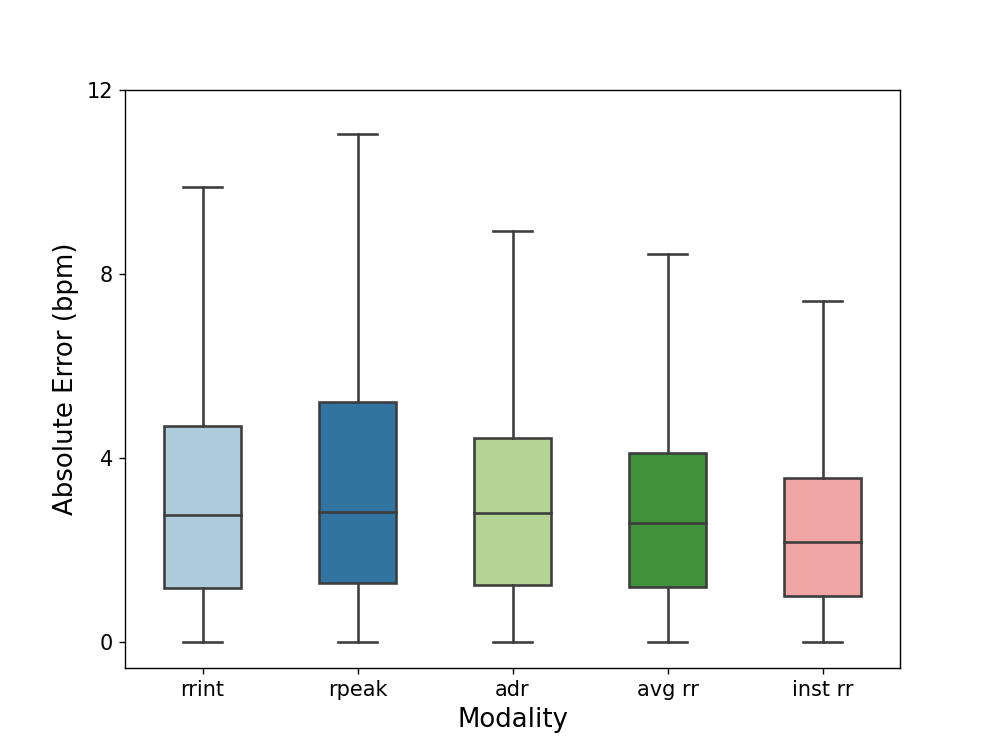

In [20]:
if input_conf =="confc" or input_conf == "confb" or input_conf == "confe" or input_conf == "RespNet":
    plt.figure(1)
    plt.rcParams["figure.figsize"] = (8,5)
    boxplot = sns.boxplot(data = error_modality_df , showfliers = False , width = 0.5 , palette="Paired")
    boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation = 0,fontsize=15)
    plt.ylabel('Absolute Error (bpm)',fontsize=15)
    #plt.grid(True,axis = 'y')
    plt.yticks(np.arange(0, 13, 4))
    plt.yticks(fontsize=12)
    plt.xticks(fontsize = 12)
    plt.xlabel('Modality',fontsize = 15)
    plt.show()
    plt.savefig('modality_plot.png')

In [21]:
if input_conf =="confc" or input_conf == "confb" or input_conf == "confe" or input_conf == "RespNet":
    array_hrv = np.concatenate((error_hrv, np.array([0 for i in range(len(error_hrv))]).reshape(-1,1),test_activity_id.reshape(-1,1)), axis = 1)
    array_rpeak = np.concatenate((error_rpeak , np.array([1 for i in range(len(error_rpeak))]).reshape(-1,1),test_activity_id.reshape(-1,1)), axis = 1)
    array_adr = np.concatenate((error_adr , np.array([2 for i in range(len(error_adr))]).reshape(-1,1),test_activity_id.reshape(-1,1)), axis = 1)
    array_fusion = np.concatenate((error_inst_breaths , np.array([3 for i in range(len(error_inst_breaths))]).reshape(-1,1),test_activity_id.reshape(-1,1)), axis = 1)

<IPython.core.display.Javascript object>


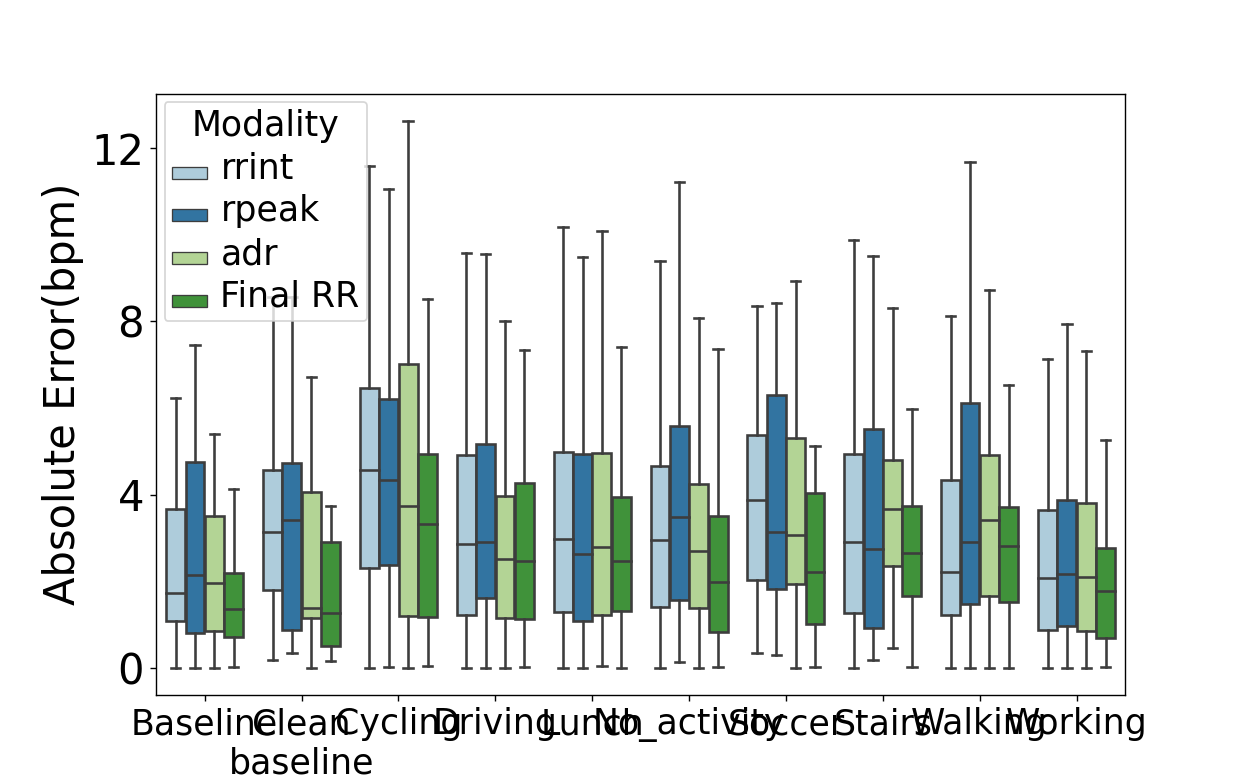

In [22]:
if input_conf =="confc" or input_conf == "confb" or input_conf == "confe" or input_conf == "RespNet":
    final_array = np.concatenate((array_hrv,array_rpeak,array_adr,array_fusion) , axis = 0)
    data_frame = pd.DataFrame(final_array , columns = ['Absolute Error(bpm)' , 'Modality' , 'Activity_id'])
    data_frame['Modality'] = data_frame['Modality'].astype('category')
    data_frame['Activity_id'] = data_frame['Activity_id'].astype('category')
    data_frame['Modality'] = data_frame['Modality'].cat.rename_categories(['rrint' , 'rpeak' , 'adr' , 'Final RR'])
    data_frame['Activity_id'] = data_frame['Activity_id'].cat.rename_categories(['Baseline' , 'Clean'+'\n'+'baseline' , 'Cycling' , 'Driving','Lunch','No_activity',
                                                      'Soccer','Stairs', 'Walking', 'Working'])
    plt.figure(2)
    plt.rcParams["figure.figsize"] = (20,11)
    ax = sns.boxplot(x="Activity_id", y="Absolute Error(bpm)", hue="Modality", data=data_frame , showfliers = False,width = 0.8,palette="Paired")
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 0,fontsize=20)
    plt.setp(ax.get_legend().get_title(), fontsize=20)
    #ax.set_yticks([i for i in range(0, int(data_frame["Absolute Error(BrPM)"].max()), 4)])
    plt.setp(ax.get_legend().get_texts(), fontsize=20)
    plt.xlabel('Activity',fontsize = 24)
    plt.ylabel('Absolute Error(bpm)',fontsize = 24)
    plt.yticks(np.arange(0, 13, 4))
    plt.yticks(fontsize=24)
    plt.show()
    plt.savefig('activity_plot.png')

In [23]:
def bland_altman_plot(predicted , truth):
    '''
    Inputs -- predicted -- Predicted Data
              Truth -- Reference Data
    Output -- None
    Description -- Function gives the bland altman plot.
    '''
    predicted = np.asarray(predicted)
    truth = np.asarray(truth)
    mean_val = np.mean([predicted , truth] , axis=0)
    diff = truth-predicted
    #print(diff)
    mean_diff = np.mean(diff)
    std_diff = np.std(diff , axis=0)
    print(mean_diff)
    print(mean_diff + 1.96*std_diff)
    print(mean_diff - 1.96*std_diff)
    plt.figure(3)
    plt.rcParams["figure.figsize"] = (10,5)
    plt.scatter(mean_val , diff,marker = 'o',facecolors='none',edgecolors='r')
    plt.axhline(mean_diff , color = 'black' , linestyle = '-' , linewidth = 3)
    plt.axhline(mean_diff + 1.96*std_diff , color = 'black' , linestyle = '--', linewidth = 3)
    plt.axhline(mean_diff - 1.96*std_diff , color = 'black' , linestyle = '--', linewidth = 3)
    plt.xlabel('Instantaneous RR(bpm)' , size = 15)
    plt.ylabel('RR_final - RR_ref(bpm)' , size = 15)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.show()
    return diff
    #plt.savefig('bland_altman.png')

In [24]:
test_activity_id.shape

(814, 1)

0.21361121813197867
[6.29129305]
[-5.86407062]


<IPython.core.display.Javascript object>


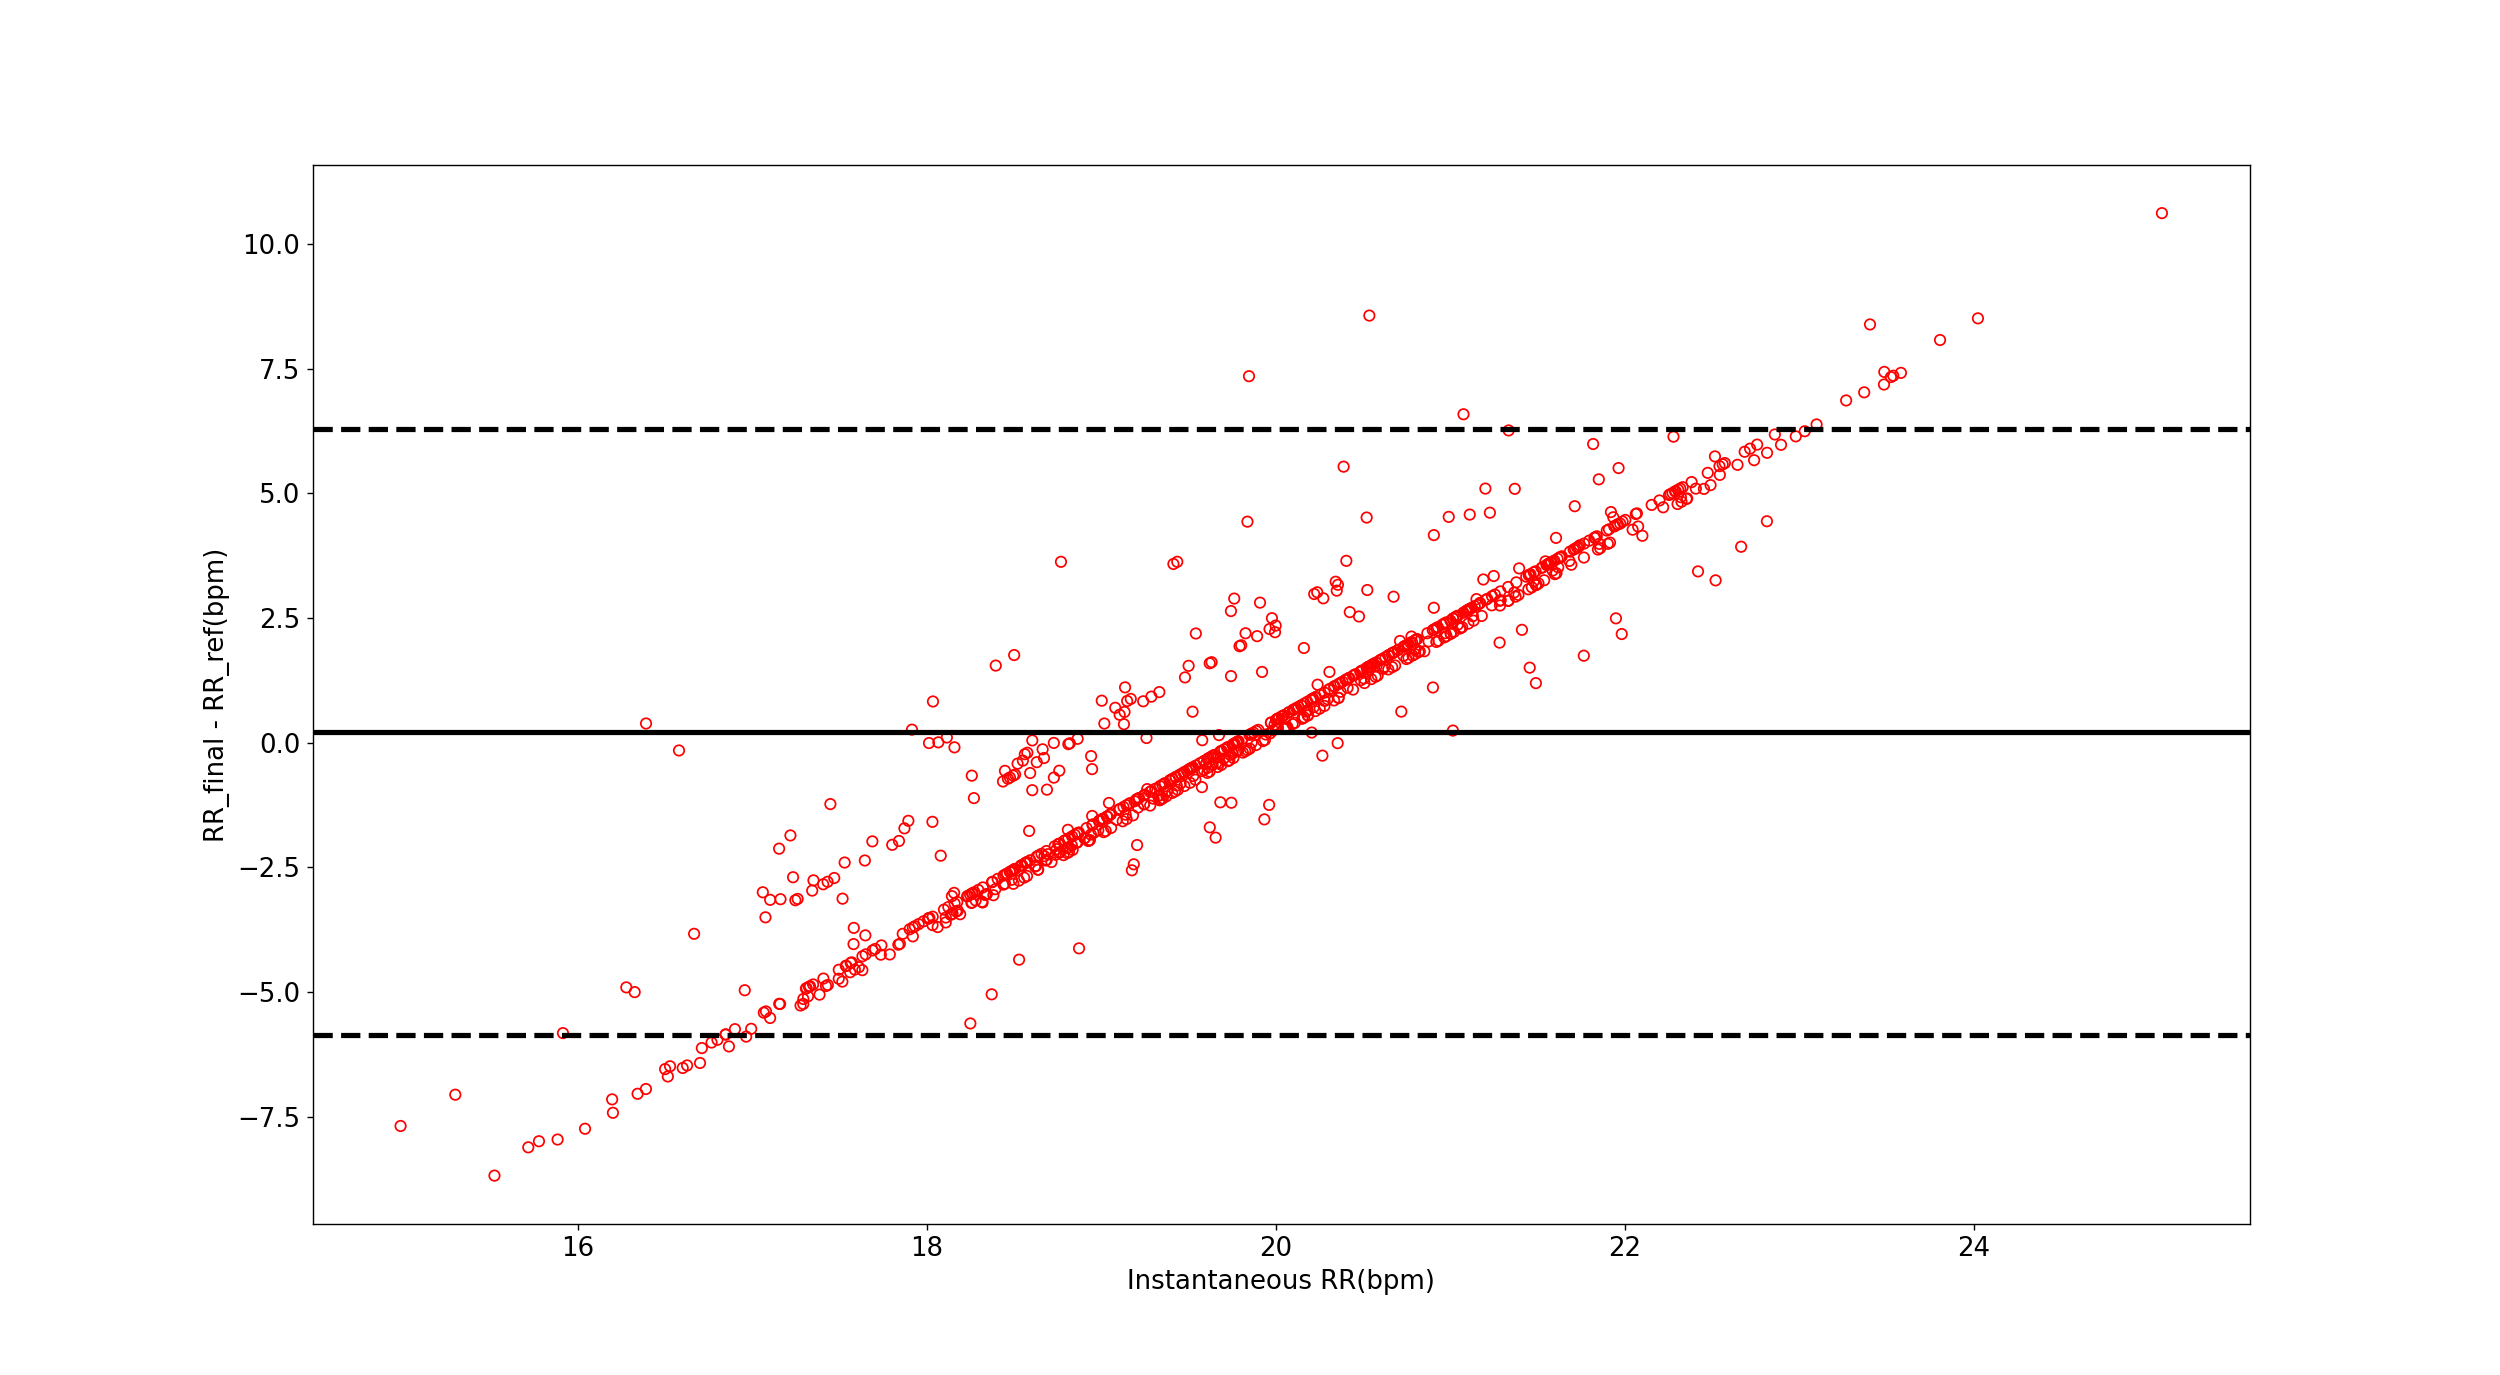

In [25]:
if input_conf =="confc" or input_conf == "confb" or input_conf == "confe" or input_conf == "RespNet":
    diff = bland_altman_plot(inst_rr,inst_ref_rr)
    

In [26]:
index = np.where(np.logical_or(diff>7.90 ,diff<-6.14))

In [27]:
act_index = test_activity_id[index]
print(act_index)
print(len(act_index))
print(set(act_index))

[5. 3. 5. 4. 4. 4. 4. 4. 4. 8. 4. 8. 5. 2. 2. 2. 5. 5. 4. 4. 4. 1.]
22
{1.0, 2.0, 3.0, 4.0, 5.0, 8.0}


In [28]:
soccer_index = np.where(act_index==6)[0]
walikng_index = np.where(act_index == 8)[0]
working_index = np.where(act_index == 9)[0]
lunch_index = np.where(act_index == 4)[0]
driving_index = np.where(act_index == 3)[0]
cycling_index = np.where(act_index == 2)[0]
baseline_index = np.where(act_index == 0)[0]
no_activity_index = np.where(act_index == 5)[0]

In [29]:
len(driving_index)

1

In [30]:
percent_no_activity = (len(no_activity_index)/len(test_activity_id))*100
percent_baseline = (len(baseline_index)/len(test_activity_id))*100
percent_cycling = (len(cycling_index)/len(test_activity_id))*100
percent_driving = (len(driving_index)/len(test_activity_id))*100
percent_lunch = (len(lunch_index)/len(test_activity_id))*100
percent_working = (len(working_index)/len(test_activity_id))*100
percent_walking = (len(walikng_index)/len(test_activity_id))*100
percent_soccer = (len(soccer_index)/len(test_activity_id))*100
print("percertage soccer is {}".format(percent_soccer))
print("percertage walking is {}".format(percent_walking))
print("percertage working is {}".format(percent_working))
print("percertage lunch is {}".format(percent_lunch))
print("percertage driving is {}".format(percent_driving))
print("percertage cycling is {}".format(percent_cycling))
print("percertage baseline is {}".format(percent_baseline))
print("percertage no activity is {}".format(percent_no_activity))

percertage soccer is 0.0
percertage walking is 0.2457002457002457
percertage working is 0.0
percertage lunch is 1.2285012285012284
percertage driving is 0.12285012285012285
percertage cycling is 0.36855036855036855
percertage baseline is 0.0
percertage no activity is 0.6142506142506142


In [31]:
if input_conf =="confc" or input_conf == "confb" or input_conf == "confe" or input_conf == "RespNet":
    error_baseline = error_inst_breaths[np.where(test_activity_id == 0)]
    error_stairs = error_inst_breaths[np.where(test_activity_id == 7)]
    error_soccer = error_inst_breaths[np.where(test_activity_id == 6)]
    error_cycling = error_inst_breaths[np.where(test_activity_id == 2)]
    error_driving = error_inst_breaths[np.where(test_activity_id == 3)]
    error_lunch = error_inst_breaths[np.where(test_activity_id == 4)]
    error_walking = error_inst_breaths[np.where(test_activity_id == 8)]
    error_working = error_inst_breaths[np.where(test_activity_id == 9)]

    error_baseline_hrv = error_hrv[np.where(test_activity_id == 0)]
    error_stairs_hrv = error_hrv[np.where(test_activity_id == 7)]
    error_soccer_hrv = error_hrv[np.where(test_activity_id == 6)]
    error_cycling_hrv = error_hrv[np.where(test_activity_id == 2)]
    error_driving_hrv = error_hrv[np.where(test_activity_id == 3)]
    error_lunch_hrv = error_hrv[np.where(test_activity_id == 4)]
    error_walking_hrv = error_hrv[np.where(test_activity_id == 8)]
    error_working_hrv = error_hrv[np.where(test_activity_id == 9)]

    error_baseline_rpeak = error_rpeak[np.where(test_activity_id == 0)]
    error_stairs_rpeak = error_rpeak[np.where(test_activity_id == 7)]
    error_soccer_rpeak = error_rpeak[np.where(test_activity_id == 6)]
    error_cycling_rpeak = error_rpeak[np.where(test_activity_id == 2)]
    error_driving_rpeak = error_rpeak[np.where(test_activity_id == 3)]
    error_lunch_rpeak = error_rpeak[np.where(test_activity_id == 4)]
    error_walking_rpeak = error_rpeak[np.where(test_activity_id == 8)]
    error_working_rpeak = error_rpeak[np.where(test_activity_id == 9)]

    error_baseline_adr = error_adr[np.where(test_activity_id == 0)]
    error_stairs_adr = error_adr[np.where(test_activity_id == 7)]
    error_soccer_adr = error_adr[np.where(test_activity_id == 6)]
    error_cycling_adr = error_adr[np.where(test_activity_id == 2)]
    error_driving_adr = error_adr[np.where(test_activity_id == 3)]
    error_lunch_adr = error_adr[np.where(test_activity_id == 4)]
    error_walking_adr = error_adr[np.where(test_activity_id == 8)]
    error_working_adr = error_adr[np.where(test_activity_id == 9)]

In [32]:
if input_conf =="confc" or input_conf == "confb" or input_conf == "confe" or input_conf == "RespNet":
    print('stairs mean abs error hrv {}'.format(np.mean(np.abs(error_stairs_hrv))))
    print('stairs mean abs error rpeak {}'.format(np.mean(np.abs(error_stairs_rpeak))))
    print('stairs mean abs error adr {}'.format(np.mean(np.abs(error_stairs_adr))))
    print('stairs mean abs error fusion {}'.format(np.mean(np.abs(error_stairs))))
    print('-----------------------------------------------------------')
    print('cycling mean abs error hrv {}'.format(np.mean(np.abs(error_cycling_hrv))))
    print('cycling mean abs error rpeak {}'.format(np.mean(np.abs(error_cycling_rpeak))))
    print('cycling mean abs error adr {}'.format(np.mean(np.abs(error_cycling_adr))))
    print('cycling mean abs error fusion {}'.format(np.mean(np.abs(error_cycling))))
    print('-----------------------------------------------------------')
    print('walking mean abs error hrv {}'.format(np.mean(np.abs(error_walking_hrv))))
    print('walking mean abs error rpeak {}'.format(np.mean(np.abs(error_walking_rpeak))))
    print('walking mean abs error adr {}'.format(np.mean(np.abs(error_walking_adr))))
    print('walking mean abs error fusion {}'.format(np.mean(np.abs(error_walking))))
    print('-----------------------------------------------------------')
    print('baseline mean abs error hrv {}'.format(np.mean(np.abs(error_baseline_hrv))))
    print('baseline mean abs error rpeak {}'.format(np.mean(np.abs(error_baseline_rpeak))))
    print('baseline mean abs error adr {}'.format(np.mean(np.abs(error_baseline_adr))))
    print('baseline mean abs error fusion {}'.format(np.mean(np.abs(error_baseline))))
    print('-----------------------------------------------------------')
    print('Driving mean abs error hrv {}'.format(np.mean(np.abs(error_driving_hrv))))
    print('Driving mean abs error rpeak {}'.format(np.mean(np.abs(error_driving_rpeak))))
    print('Driving mean abs error adr {}'.format(np.mean(np.abs(error_driving_adr))))
    print('Driving mean abs error fusion {}'.format(np.mean(np.abs(error_driving))))
    print('-----------------------------------------------------------')
    print('Cycling mean abs error hrv {}'.format(np.mean(np.abs(error_cycling_hrv))))
    print('Cycling mean abs error rpeak {}'.format(np.mean(np.abs(error_cycling_rpeak))))
    print('Cycling mean abs error adr {}'.format(np.mean(np.abs(error_cycling_adr))))
    print('Cycling mean abs error fusion {}'.format(np.mean(np.abs(error_cycling))))
    print('---------------------------------------------------------------------------')
    print('lunch mean abs error hrv {}'.format(np.mean(np.abs(error_lunch_hrv))))
    print('lunch mean abs error rpeak {}'.format(np.mean(np.abs(error_lunch_rpeak))))
    print('lunch mean abs error adr {}'.format(np.mean(np.abs(error_lunch_adr))))
    print('lunch mean abs error fusion {}'.format(np.mean(np.abs(error_lunch))))
    print('---------------------------------------------------------------------------')
    print('working mean abs error hrv {}'.format(np.mean(np.abs(error_working_hrv))))
    print('working mean abs error rpeak {}'.format(np.mean(np.abs(error_working_rpeak))))
    print('working mean abs error adr {}'.format(np.mean(np.abs(error_working_adr))))
    print('working mean abs error fusion {}'.format(np.mean(np.abs(error_working))))

stairs mean abs error hrv 3.822254195224879
stairs mean abs error rpeak 3.4787966874727174
stairs mean abs error adr 4.275353993282093
stairs mean abs error fusion 2.7140197869467757
-----------------------------------------------------------
cycling mean abs error hrv 4.4447008284498
cycling mean abs error rpeak 4.493902171951423
cycling mean abs error adr 4.2591611065977295
cycling mean abs error fusion 3.4993983895779532
-----------------------------------------------------------
walking mean abs error hrv 3.0955062714006365
walking mean abs error rpeak 3.9253230280936506
walking mean abs error adr 3.4335348732344144
walking mean abs error fusion 2.781328813500871
-----------------------------------------------------------
baseline mean abs error hrv 2.2801591446564937
baseline mean abs error rpeak 2.808892323908228
baseline mean abs error adr 2.325681799732599
baseline mean abs error fusion 1.5385255431276854
-----------------------------------------------------------
Driving mean 

In [33]:
inst_hrv_dur = []
inst_rpeak_dur = []
inst_adr_dur = []
inst_ref_br_dur = []

new_inst_hrv_rr = []
new_inst_rpeak_rr = []
new_inst_adr_rr = []
new_inst_ref_rr = []

In [34]:
for item in extremas_ref_resp:
    inst_ref_br_dur.append(np.diff(item[0::2]))

for item in extremas_hrv:
    inst_hrv_dur.append(np.diff(item[0::2]))

for item in extremas_rpeak:
    inst_rpeak_dur.append(np.diff(item[0::2]))

for item in extremas_adr:
    inst_adr_dur.append(np.diff(item[0::2]))

    
for item in inst_ref_br_dur:
    #print(np.mean(60*4/item))
    new_inst_ref_rr.append(np.mean(60*4/item))

for item in inst_hrv_dur:
    new_inst_hrv_rr.append(np.mean(60*4/item))
    
for item in inst_rpeak_dur:
    new_inst_rpeak_rr.append(np.mean(60*4/item))
        
                         
for item in inst_adr_dur:
    new_inst_adr_rr.append(np.mean(60*4/item))
                         

In [35]:
new_inst_ref_rr = np.array(new_inst_ref_rr).reshape(-1,1)
new_inst_hrv_rr = np.array(new_inst_hrv_rr).reshape(-1,1)
new_inst_rpeak_rr = np.array(new_inst_rpeak_rr).reshape(-1,1)
new_inst_adr_rr = np.array(new_inst_adr_rr).reshape(-1,1)


print(len(new_inst_ref_rr))
print(len(new_inst_hrv_rr))
print(len(new_inst_rpeak_rr))
print(len(new_inst_adr_rr))

814
814
814
814


In [36]:
inst_err_hrv = np.abs(inst_ref_rr - new_inst_hrv_rr)
inst_err_rpeak = np.abs(inst_ref_rr - new_inst_rpeak_rr)
inst_err_adr = np.abs(inst_ref_rr - new_inst_adr_rr)


inst_mae_hrv = np.mean(inst_err_hrv)
inst_mae_rpeak = np.mean(inst_err_rpeak)
inst_mae_adr = np.mean(inst_err_adr)

rmse_inst_hrv = np.sqrt(np.mean(inst_err_hrv**2))
rmse_inst_rpeak = np.sqrt(np.mean(inst_err_rpeak**2))
rmse_inst_adr = np.sqrt(np.mean(inst_err_adr**2))


print(inst_mae_hrv)
print(inst_mae_rpeak)
print(inst_mae_adr)


print(rmse_inst_hrv)
print(rmse_inst_rpeak)
print(rmse_inst_adr)

3.5429675531442144
3.8280677315578537
3.4928508216443315
4.511286595341353
4.850001789544033
4.3535119585971485
